In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
from random import randint
from IPython.display import clear_output
import ast

In [2]:
train_anns = dict()
train_anns['images'] = []
train_anns['annotations'] = []
train_anns['categories'] = [{'id': 0, 'name': 'wheat'}]
iid = 0
im2id = {}
aid = 0


In [3]:
## Init constant
DATA_DIR = './data/Wheatdetection'
IMG_DIR = f"{DATA_DIR}/train"
TARGETS = ['arvalis_1', 'arvalis_2', 'arvalis_3', 'inrae_1', 'usask_1', 'rres_1', 'ethz_1']
N_PATCH = [(2, 3), (2, 2), (2, 2), (2, 2), (1, 2), (2, 3), (1, 2)]
BOX_COLOR = [0,0,255]

### Image utils function

In [4]:
def plot_img(img, size=(7,7), is_rgb=False, title=""):
    if isinstance(img, str):
        img = load_img(img)
    plt.figure(figsize=size)
    if is_rgb:
        plt.imshow(img)
    else:
        plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=5, size=7, is_rgb=False, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if isinstance(img, str):
            img = load_img(img, size=300)
        fig.add_subplot(rows, cols, i+1)
        if is_rgb:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,::-1])
    plt.suptitle(title)
    plt.show()
    
def visualize_bbox(img, boxes, thickness=3, color=BOX_COLOR):
    img_copy = img.copy()
    for box in boxes:
        #if(box[0] > 900 or box[1] > 900 or box[2] > 900 or box[3] > 900):
        if(box[0]%1024==0 or box[1]%1024==0 or box[2]%1024==0 or box[3]%1024==0):
          #if(box[0]% 1024 < 50 or box[0]%1024 > 970 or box[2]% 1024 < 50 or box[2]%1024 > 970 or box[1]% 1024 < 50 or box[1]%1024 > 970 or box[3]% 1024 < 50 or box[3]%1024 > 970):
            img_copy = cv2.rectangle(
                img_copy,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color, thickness)
    return img_copy

def load_img(img_id):
    cv2.imread(f"{IMG_DIR}/{img_id}.jpg")

In [5]:

df = pd.read_csv(f"{DATA_DIR}/train.csv")
df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(np.stack(df['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)
df['x2'] = df['x1'] + df['w']
df['y2'] = df['y1'] + df['h']
df.head()

image_id  width  height                         bbox   source     x1  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

      y1      w      h     x2     y2  
0  222.0   56.0   36.0  890.0  258.0  
1  548.0  130.0   58.0  356.0  606.0  
2  504.0   74.0  160.0  451.0  664.0  
3   95.0  109.0  107.0  943.0  202.0  
4  144.0  124.0  117.0  150.0  261.0

In [6]:
marking = pd.read_csv(f"{DATA_DIR}/train.csv")
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

print(set(df_folds.source.values))

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
val_id = df_folds[df_folds['fold'] == fold_number].index.values


def combine_result_masked(patch_grid, df):
    h, w = patch_grid.shape
    total_img = np.zeros((h*1024, w*1024, 3))
    all_boxes = []
    patch_img_ids = []
    
    for r in range(h):
        for c in range(w):
            img_id = patch_grid[r, c]["img_id"]
            patch_img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
            
            xrange = [c*1024, (c+1)*1024]
            yrange = [r*1024, (r+1)*1024]
            
            #print(img_id)
            if img_id not in val_id:
                total_img[
                    yrange[0] : yrange[1],
                    xrange[0] : xrange[1], :
                ] = patch_img
            
            boxes = df[df["image_id"] == img_id][["x1", 'y1', 'x2', 'y2']]
            boxes["x1"] += xrange[0]
            boxes["x2"] += xrange[0]
            boxes["y1"] += yrange[0]
            boxes["y2"] += yrange[0]
            all_boxes.append(boxes)
            patch_img_ids.append(img_id)
    all_boxes = pd.concat(all_boxes)
    total_img = total_img.astype(np.uint8)
    return total_img, all_boxes, patch_img_ids

{'usask_1', 'arvalis_3', 'inrae_1', 'arvalis_1', 'rres_1', 'arvalis_2', 'ethz_1'}


/home/peiyuanl/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


## Get left, right, top, bottom edges each image 

# Note: Run this for each tar_id for several times to generate COCO

In [7]:
TAR_ID = 4
img_ids = df[df["source"] == TARGETS[TAR_ID]]["image_id"].unique()
IMG_N = len(img_ids)
print(IMG_N)

l_edges = []
r_edges = []
t_edges = []
b_edges = []

for i, img_id in enumerate(img_ids):
    img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
    ## normalize values by dividing max values
    l_edges.append(img[:,:1,:] / img[:,:1,:].max())
    r_edges.append(img[:,-1:,:] / img[:,-1:,:].max())
    t_edges.append(img[:1,:,:] / img[:1,:,:].max())
    b_edges.append(img[-1:,:,:] / img[-1:,:,:].max())
    
l_edges = np.squeeze(np.array(l_edges))
r_edges = np.squeeze(np.array(r_edges))
t_edges = np.squeeze(np.array(t_edges))
b_edges = np.squeeze(np.array(b_edges))

200


## Compute left-right distance, top-bottom distance matrix

LR_distance[i,j]: distance between I image's left edge and J image's right edge

TB_distance[i,j]: distance between I image's top edge and J image's bottom edge

In [8]:
def distance(edge1, edge2):
    d1 = np.abs(edge1 - edge2).mean()
    d2 = np.abs(edge1[1:,:] - edge2[:-1,:]).mean()
    d3 = np.abs(edge2[1:,:] - edge1[:-1,:]).mean()
    total_distance = d1+d2+d3
    return total_distance


LR_distance = np.zeros((IMG_N, IMG_N)) + 1e3
TB_distance = np.zeros((IMG_N, IMG_N)) + 1e3

for i, left in enumerate(l_edges):
    for j, right in enumerate(r_edges):
        if i == j:
            continue
        LR_distance[i,j] = distance(left, right)
print(LR_distance.shape)


for i, top in enumerate(t_edges):
    for j, bottom in enumerate(b_edges):
        if i == j:
            continue
        TB_distance[i,j] = distance(top, bottom)
print(TB_distance.shape)

(200, 200)
(200, 200)


# Search best matches 

In [9]:
def get_best_bottom_img(top_id, TB_distance):
    index = np.argmin(TB_distance[:, top_id])
    distance = TB_distance[index, top_id]
    return index, distance

def get_best_right_img(left_id, LR_distance):
    index = np.argmin(LR_distance[:, left_id])
    distance = LR_distance[index, left_id]
    return index, distance

def get_best_right_bottom_img(top_id, left_id, TB_distance, LR_distance):
    index = np.argmin(TB_distance[:, top_id] + LR_distance[:, left_id])
    distance = (TB_distance[index, top_id] + LR_distance[index, left_id])/2
    return index, distance

def index_grid_to_info_grid(patch_grid, img_ids):
    h_grid, w_grid = patch_grid.shape
    PATCH_INFO_GRID = np.zeros(patch_grid.shape).astype(np.object)
    for row in range(h_grid):
        for col in range(w_grid):
            index = patch_grid[row, col]
            PATCH_INFO_GRID[row, col] = {
                "index": index,
                "img_id": img_ids[index]
            }
    return PATCH_INFO_GRID


## Convert index-grid to info-grid
def combine_result(patch_grid, df):
    h, w = patch_grid.shape
    total_img = np.zeros((h*1024, w*1024, 3))
    all_boxes = []
    patch_img_ids = []
    
    for r in range(h):
        for c in range(w):
            img_id = patch_grid[r, c]["img_id"]
            patch_img = cv2.imread(f"{IMG_DIR}/{img_id}.jpg")
            
            xrange = [c*1024, (c+1)*1024]
            yrange = [r*1024, (r+1)*1024]
            total_img[
                yrange[0] : yrange[1],
                xrange[0] : xrange[1], :
            ] = patch_img
            
            boxes = df[df["image_id"] == img_id][["x1", 'y1', 'x2', 'y2']]
            boxes["x1"] += xrange[0]
            boxes["x2"] += xrange[0]
            boxes["y1"] += yrange[0]
            boxes["y2"] += yrange[0]
            all_boxes.append(boxes)
            patch_img_ids.append(img_id)
    all_boxes = pd.concat(all_boxes)
    total_img = total_img.astype(np.uint8)
    return total_img, all_boxes, patch_img_ids

## Main stratery

In [10]:
print(TAR_ID)
THRESHOLDS = [0.25, 0.33, 0.25, 0.25, 0.2, 0.1, 0.25]
threshold = THRESHOLDS[TAR_ID]
ALL_PATCH_GRIDS = []

for i, img_id in enumerate(img_ids):
    PATCH_GRID = np.zeros(N_PATCH[TAR_ID]).astype(np.object)
    h_grid, w_grid = PATCH_GRID.shape 
    PATCH_GRID[0,0] = i
    all_distance = []
    
    for row in range(h_grid):
        for col in range(w_grid):
            if col == 0 and row == 0:
                continue
            if col == 0:
                top_id = int(PATCH_GRID[row-1, col])
                PATCH_GRID[row, col], distance = get_best_bottom_img(top_id, TB_distance)
            if row == 0:
                left_id = int(PATCH_GRID[row, col-1])
                PATCH_GRID[row, col], distance = get_best_right_img(left_id, LR_distance)
            if row*col > 0:
                top_id = PATCH_GRID[row-1,col]
                left_id = PATCH_GRID[row, col-1]
                PATCH_GRID[row, col], distance = get_best_right_bottom_img(
                    top_id, left_id,
                    TB_distance, LR_distance
                )
            all_distance.append(distance)

    avg_distance = np.mean(all_distance)
    if avg_distance < threshold:
        ALL_PATCH_GRIDS.append(PATCH_GRID)
        
print(len(ALL_PATCH_GRIDS))

4
99


## Save new data

Remove the comment code if you want to save data

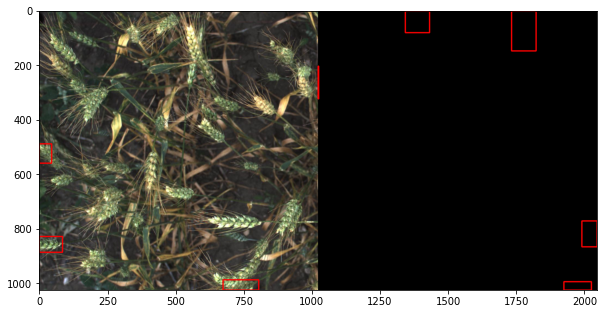

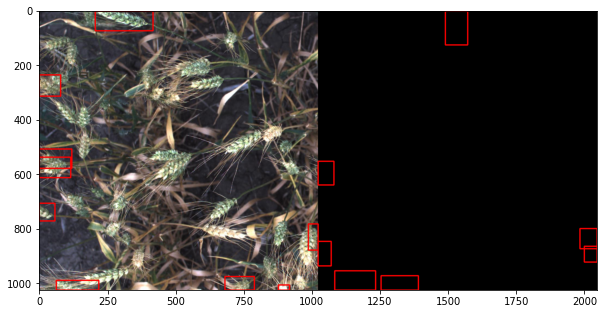

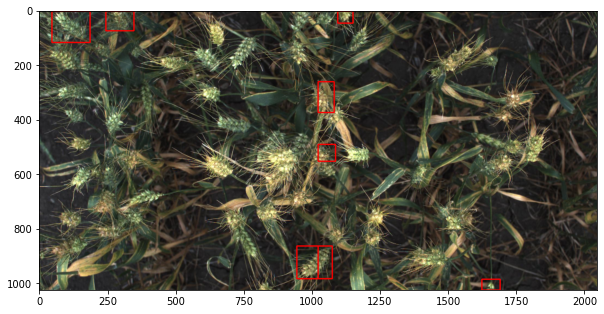

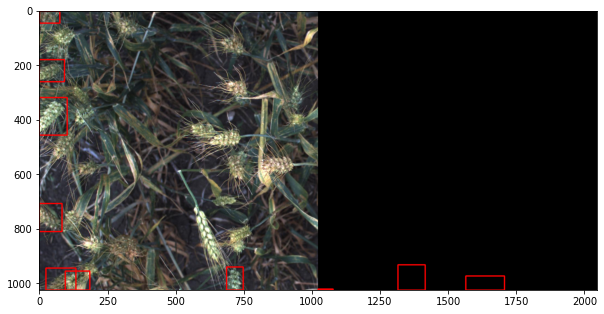

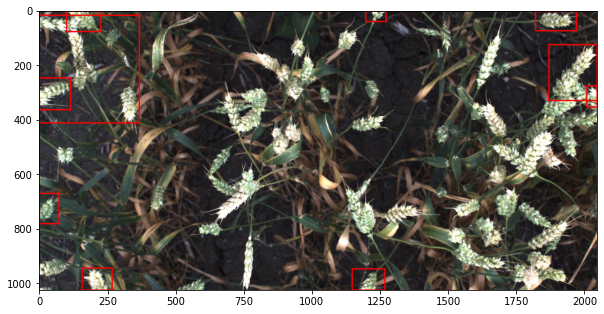

SAVE NEW DATA IN: origin_usask_1.csv


In [11]:
all_new_data = []
source = TARGETS[TAR_ID]
new_img_dir = "origin_img_masked" 
os.makedirs(new_img_dir, exist_ok=True)

for i, patch_grid in enumerate(ALL_PATCH_GRIDS):
    patch_grid = index_grid_to_info_grid(patch_grid, img_ids)
    total_img, boxes, patch_img_ids = combine_result_masked(patch_grid, df)
    bimg = total_img.copy()
    #print(boxes)
    for box in boxes.iterrows():
        box = box[1]
        bimg = cv2.rectangle(bimg,(box.x1, box.y1),(box.x2, box.y2),(102,255,0), 3)
    new_img_ids = source + '_' + "_".join(patch_img_ids)
    boxes["image_id"] = new_img_ids
    all_new_data.append(boxes)
    cv2.imwrite(f"{new_img_dir}/{new_img_ids}.jpg", total_img)
    cv2.imwrite(f"annotated/{new_img_ids}_annotated.jpg", bimg)
    
    if i < 5:
        total_img = visualize_bbox(total_img, boxes.values)
        plot_img(total_img, size=(10,10))
        #print(new_img_ids)

all_new_data = pd.concat(all_new_data)
csv_path = f"origin_{source}.csv"
print(f"SAVE NEW DATA IN: {csv_path}")

all_new_data.to_csv(csv_path)

In [11]:
all_new_data

x1     y1      x2     y2                     image_id
0      834.0  222.0   890.0  258.0  usask_1_b6ab77fd7_2cc952ee8
1      226.0  548.0   356.0  606.0  usask_1_b6ab77fd7_2cc952ee8
2      377.0  504.0   451.0  664.0  usask_1_b6ab77fd7_2cc952ee8
3      834.0   95.0   943.0  202.0  usask_1_b6ab77fd7_2cc952ee8
4       26.0  144.0   150.0  261.0  usask_1_b6ab77fd7_2cc952ee8
...      ...    ...     ...    ...                          ...
5406  1431.0  788.0  1635.0  887.0  usask_1_69855d3de_7e75b3e43
5407  1104.0   87.0  1211.0  187.0  usask_1_69855d3de_7e75b3e43
5408  1070.0  883.0  1243.0  961.0  usask_1_69855d3de_7e75b3e43
5409  1894.0  440.0  2018.0  605.0  usask_1_69855d3de_7e75b3e43
5410  1680.0  208.0  1734.0  346.0  usask_1_69855d3de_7e75b3e43

[5749 rows x 5 columns]

In [12]:
for im in tqdm(list(set(all_new_data.image_id.values))):
    image = cv2.imread(f"{new_img_dir}/{new_img_ids}.jpg")
    height, width, _ = image.shape
    image = {
        'file_name': f"{im}.jpg",
        'height': height,
        'width': width,
        'id': iid
            }
    train_anns['images'].append(image)
    im2id[im] = iid
    iid+=1
    #print(image.shape)
    #break

area = lambda x: (int(x[3])-int(x[1]))*(int(x[2])-int(x[0]))
for _, row in tqdm(all_new_data.iterrows()):
    #print(eval(row.bbox))
    bbox = [row.x1, row.y1, row.x2, row.y2]
    x = bbox
    ann = {
        'segmentation': [[x[0],x[1], #(x1, y1)
                          x[2],x[1], #(x2, y1)
                          x[2],x[3], #(x2, y2)
                          x[0],x[3]]], #(x1, y1)
        'area': area(bbox),
        'iscrowd': 0,
        'image_id': im2id[row.image_id],
        'bbox': bbox,
        'category_id': 0,
        'id': aid
    }
    aid += 1
    train_anns['annotations'].append(ann)
    #break

100%|██████████| 99/99 [00:02<00:00, 48.05it/s]
5749it [00:00, 7852.99it/s]


In [13]:
#train_anns

In [14]:
import json
"""
ANN = '/home/peiyuanl/kaggle/wheat_det/'
# Serializing json  
json_object = json.dumps(train_anns, indent = 4) 

with open(ANN+"full_annotations.json", "w") as outfile: 
    outfile.write(json_object) 
"""

'\nANN = \'/home/peiyuanl/kaggle/wheat_det/\'\n# Serializing json  \njson_object = json.dumps(train_anns, indent = 4) \n\nwith open(ANN+"full_annotations.json", "w") as outfile: \n    outfile.write(json_object) \n'

In [15]:
df = all_new_data

In [16]:
ut = 1
lt = 1023
a = df.loc[df['x1']==1024]
b = df.loc[df['x2']==1024]
#c = df.loc[df['y1']%1024<ut]
#d = df.loc[df['y2']%1024<ut]
#e = df.loc[df['x1']%1024>lt]
#f = df.loc[df['x2']%1024>lt]
#g = df.loc[df['y1']%1024>lt]
#h = df.loc[df['y2']%1024>lt]
#(box[0]%1024==0 or box[1]%1024==0 or box[2]%1024==0 or box[3]%1024==0):

In [17]:
cands = pd.concat([a,b]).drop_duplicates()
rest = df[~df.apply(tuple,1).isin(cands.apply(tuple,1))]

In [18]:
len(set(cands.image_id.values))

93

In [19]:
def overlap(ax1, ax2, bx1, bx2):
    #print(bx1, bx2)
    #print(ax1, ax2, bx1, bx2)
    if (ax1 > bx2) or (bx1 > ax2): return -1
    intersection = bx2 - ax1 if ax2 > bx2 else ax2 - bx1
    union = max(ax2, bx2) - min(ax1, bx1)
    #print(intersection, union)
    return float(intersection)/float(union)

In [20]:
from functools import reduce

csvs = []
for im in list(set(cands.image_id.values)):
    print('===============')
    print(im)
    imdf = (cands.loc[cands['image_id']==im])
    
    mat = imdf[['x1','y1','x2','y2']].values
    
    x1 = imdf[['x1']].values.reshape(-1)
    x2 = imdf[['x2']].values.reshape(-1)
    y1 = imdf[['y1']].values.reshape(-1)
    y2 = imdf[['y2']].values.reshape(-1)

    matched_pairs = []
    matched_boxes = []
    visited = set()
    
    threshold = 200
    matches = np.where(x2==1024)[0]
    
    r_cands = np.where(x1==1024)[0]
    
    print(matches, r_cands)
    
    for idx in r_cands:
        if idx in visited: continue
        if x1[idx] != 1024: continue
        
        #print(matches)
        if (len(matches) > 0):
            ay1 = y1[idx]
            ay2 = y2[idx]
            
            max_id = -1
            max_cov = -1
            for ma in matches:
                if ma in visited: continue
                cov = overlap(ay1,ay2,y1[ma],y2[ma]) 
                print(ay1,ay2,y1[ma],y2[ma])
                print("[idx {}, idx2 {}]: {}".format(idx, ma, cov))
                if cov == -1: continue
                if cov > max_cov:
                    max_id = ma
                    max_cov = cov
                    
            if (max_cov > 0.4):
                matched_pairs.append((idx,max_id))
                assert idx not in visited
                assert max_id not in visited
                visited.add(idx)
                visited.add(max_id)
                dx1 = min(x1[idx],x1[max_id])
                dy1 = min(y1[idx],y1[max_id])
                dx2 = max(x2[idx],x2[max_id])
                dy2 = max(y2[idx],y2[max_id])
                data = {
                    'image_id':im,
                    'x1': dx1,
                    'y1': dy1,
                    'x2': dx2,
                    'y2': dy2,
                }
                matched_boxes.append(pd.DataFrame(columns=['x1','y1','x2','y2','image_id'],data=data,index=[0]))
                
    print(matched_pairs) 
    #matched_indices = list(reduce(lambda x,y: x+y, matched_pairs)) if len(matched_pairs) > 0 else []
    #print(matched_indices)
    unmatched_indices = [i for i in range(len(x1)) if i not in visited]
    unmatched_boxes = imdf.iloc[unmatched_indices]
    
    matched_boxes = pd.concat(matched_boxes) if len(matched_boxes) > 0 else None
    csv=pd.concat([matched_boxes, unmatched_boxes]) if matched_boxes is not None else unmatched_boxes
    #print(csv)
    csvs.append(csv)
    #break

usask_1_5343c02b0_48c72c991
[2 3] [0 1]
111.0 197.0 942.0 1022.0
[idx 0, idx2 2]: -1
111.0 197.0 127.0 194.0
[idx 0, idx2 3]: 0.9651162790697675
939.0 1009.0 942.0 1022.0
[idx 1, idx2 2]: 0.8072289156626506
[(0, 3), (1, 2)]
usask_1_05dfa9bb1_9181010cc
[4 5 6] [0 1 2 3]
182.0 250.0 165.0 231.0
[idx 0, idx2 4]: 0.5764705882352941
182.0 250.0 865.0 985.0
[idx 0, idx2 5]: -1
182.0 250.0 245.0 406.0
[idx 0, idx2 6]: 0.022321428571428572
897.0 976.0 865.0 985.0
[idx 1, idx2 5]: 0.925
897.0 976.0 245.0 406.0
[idx 1, idx2 6]: -1
94.0 210.0 245.0 406.0
[idx 2, idx2 6]: -1
315.0 404.0 245.0 406.0
[idx 3, idx2 6]: 0.9875776397515528
[(0, 4), (1, 5), (3, 6)]
usask_1_4a4a1d3e0_9bedf6645
[] [0]
[]
usask_1_4d60c73db_e91d7c41b
[] [0 1]
[]
usask_1_83a5d8ac8_1def04f70
[3 4] [0 1 2]
0.0 86.0 884.0 944.0
[idx 0, idx2 3]: -1
0.0 86.0 429.0 525.0
[idx 0, idx2 4]: -1
842.0 962.0 884.0 944.0
[idx 1, idx2 3]: 0.85
842.0 962.0 429.0 525.0
[idx 1, idx2 4]: -1
419.0 502.0 429.0 525.0
[idx 2, idx2 4]: 0.6886792452

358.0 426.0 366.0 470.0
[idx 3, idx2 6]: 0.5357142857142857
[(2, 5), (3, 6)]
usask_1_a0d6d5690_c64a4006c
[4 5 6 7 8 9] [0 1 2 3]
579.0 679.0 261.0 353.0
[idx 0, idx2 4]: -1
579.0 679.0 393.0 492.0
[idx 0, idx2 5]: -1
579.0 679.0 828.0 964.0
[idx 0, idx2 6]: -1
579.0 679.0 638.0 725.0
[idx 0, idx2 7]: 0.2808219178082192
579.0 679.0 591.0 659.0
[idx 0, idx2 8]: 0.8
579.0 679.0 138.0 242.0
[idx 0, idx2 9]: -1
111.0 198.0 261.0 353.0
[idx 1, idx2 4]: -1
111.0 198.0 393.0 492.0
[idx 1, idx2 5]: -1
111.0 198.0 828.0 964.0
[idx 1, idx2 6]: -1
111.0 198.0 638.0 725.0
[idx 1, idx2 7]: -1
111.0 198.0 138.0 242.0
[idx 1, idx2 9]: 0.4580152671755725
258.0 391.0 261.0 353.0
[idx 2, idx2 4]: 0.7142857142857143
258.0 391.0 393.0 492.0
[idx 2, idx2 5]: -1
258.0 391.0 828.0 964.0
[idx 2, idx2 6]: -1
258.0 391.0 638.0 725.0
[idx 2, idx2 7]: -1
402.0 517.0 393.0 492.0
[idx 3, idx2 5]: 0.7258064516129032
402.0 517.0 828.0 964.0
[idx 3, idx2 6]: -1
402.0 517.0 638.0 725.0
[idx 3, idx2 7]: -1
[(0, 8), (1, 9

In [21]:
corrected_3 = pd.concat(csvs)
corrected_3 = pd.concat([rest,corrected_3])

In [22]:
corrected = corrected_3#pd.concat(csvs)
csv_path = f"/home/peiyuanl/kaggle/wheat_det/data/Wheatdetection/fullsize/origin_{source}_corrected.csv"

corrected.to_csv(csv_path,index=False)

In [23]:
csvs[35]

x1     y1      x2     y2                     image_id
0  968.0  239.0  1137.0  365.0  usask_1_afb7671e5_1aebf1c4c

In [24]:
matched_pairs

[]

In [25]:
from functools import reduce

reduce(lambda x,y: x+y, [(0,1),(2,3)])

(0, 1, 2, 3)

/home/peiyuanl/kaggle/wheat_det/origin_img/usask_1_afb7671e5_1aebf1c4c.jpg
[1024.  239. 1137.  362.]
[ 968.  272. 1024.  365.]
--------
[ 968.  239. 1137.  365.]


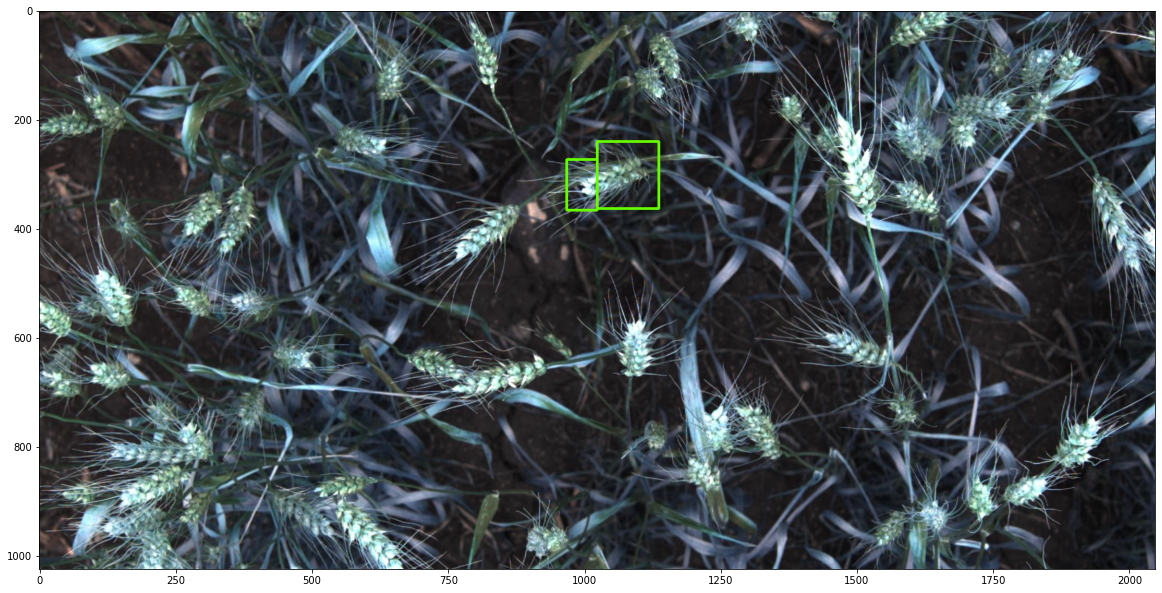

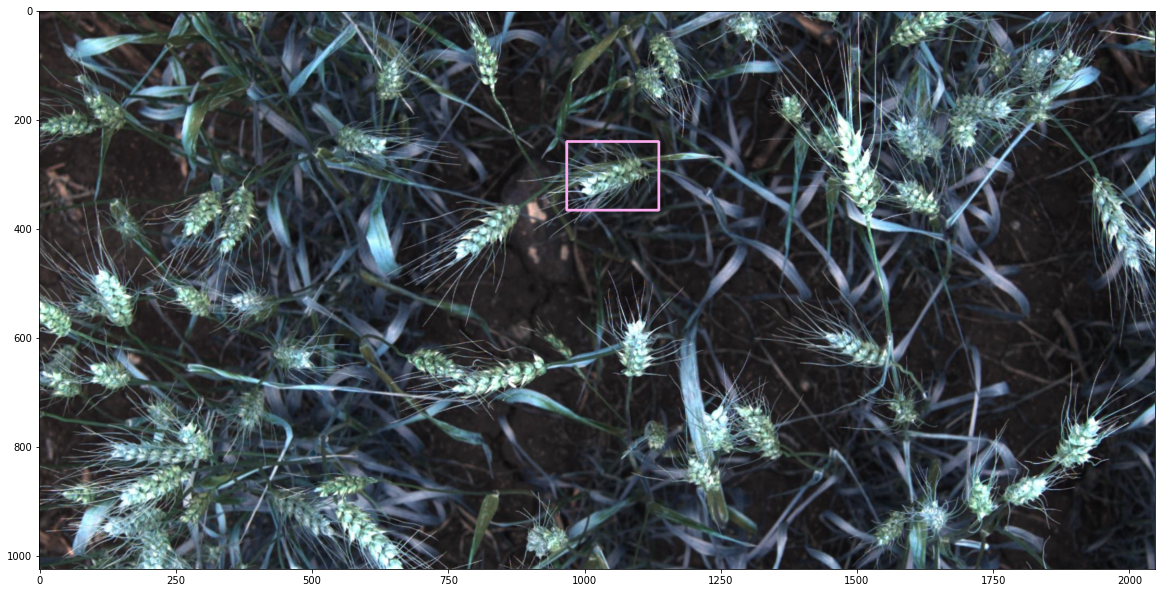

In [26]:
color = list(np.random.choice(range(256), size=100))

idx = 35

imid = csvs[idx].image_id.values[0]
size = 20
fig, ax = plt.subplots(1, 1, figsize=(size, size))
DIR_TEST = '/home/peiyuanl/kaggle/wheat_det/origin_img'
img_pth = os.path.join(DIR_TEST, imid+'.jpg')
print(img_pth)
image = cv2.imread(img_pth)

#boxes = [mat[41], mat[60]]
#boxes = mat[x1_cands]
boxes = cands.loc[cands['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
for box in boxes:
    print(box)
    image = cv2.rectangle(image,(box[0], box[1]),(box[2], box[3]),(102,255,0), 3)
    i+=1

ax.imshow(image)

print('--------')

fig2, ax2 = plt.subplots(1, 1, figsize=(size, size))
image2 = cv2.imread(img_pth)

boxes = csvs[idx][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
k = 0
for box in boxes:
    print(box)
    if i % 2 == 0:
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image2 = cv2.rectangle(image2,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax2.imshow(image2)

/home/peiyuanl/kaggle/wheat_det/origin_img/usask_1_7b72ea0fb_43650fd9c.jpg
--------


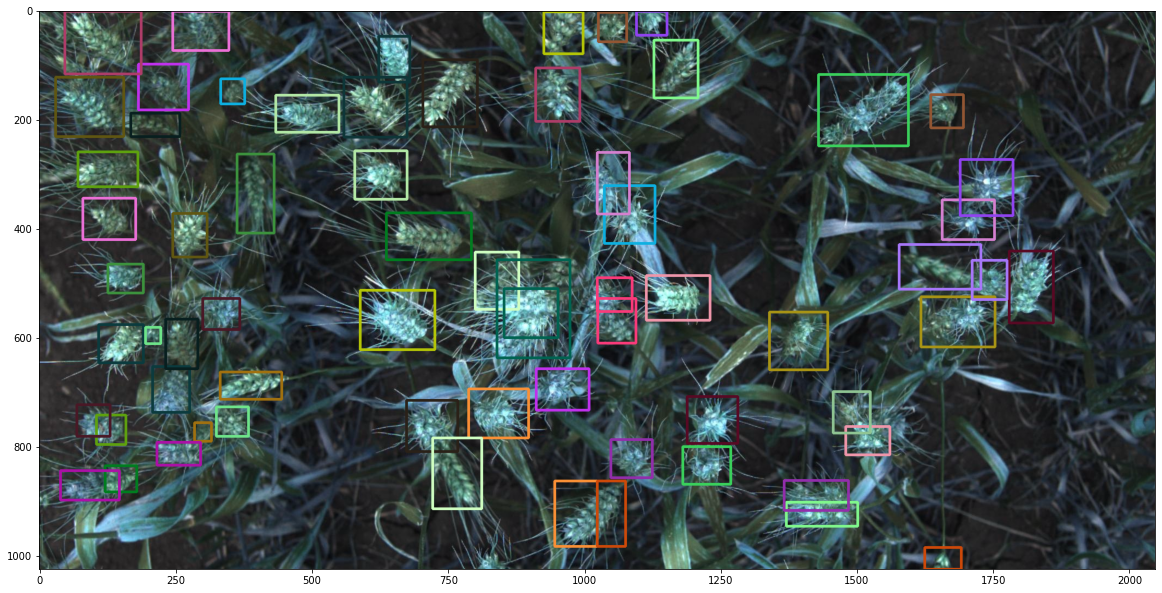

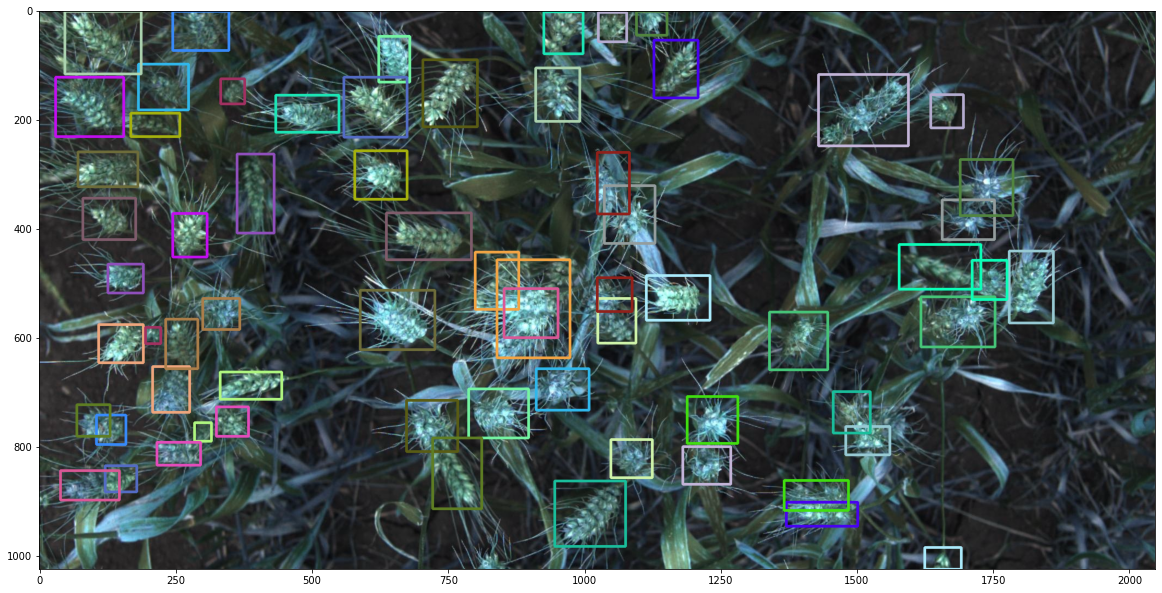

In [29]:
color = list(np.random.choice(range(256), size=300))

idx = 65

imid = csvs[idx].image_id.values[0]
size = 20
fig, ax = plt.subplots(1, 1, figsize=(size, size))
DIR_TEST = '/home/peiyuanl/kaggle/wheat_det/origin_img'
img_pth = os.path.join(DIR_TEST, imid+'.jpg')
print(img_pth)
image = cv2.imread(img_pth)

#boxes = [mat[41], mat[60]]
#boxes = mat[x1_cands]
boxes = df.loc[df['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
for box in boxes:
    #print(box)
    if i % 2 == 0:
        k%=295
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image = cv2.rectangle(image,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax.imshow(image)

print('--------')

fig2, ax2 = plt.subplots(1, 1, figsize=(size, size))
image2 = cv2.imread(img_pth)

boxes = corrected.loc[corrected['image_id']==imid][['x1','y1','x2','y2']].values
#boxes = [mat[0], mat[2]]
#np.random.shuffle(boxes)
#print(boxes.shape)
i = 0
k = 0
for box in boxes:
    #print(box)
    if i % 2 == 0:
        k%=295
        colors = (int(color[k]), int(color[k+1]), int(color[k+2]))
        k+=3
    image2 = cv2.rectangle(image2,(box[0], box[1]),(box[2], box[3]),colors, 3)
    i+=1

ax2.imshow(image2)

In [ ]:
pd.concat([a,b,c,d]).drop_duplicates()

In [ ]:
b =pd.concat([df,df])

In [ ]:
b.drop_duplicates() == df

In [ ]:
set([1,2,3]) - set([1])

In [ ]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import json